In [1]:
%load_ext autoreload
%autoreload 2

In [63]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder
from pytensor_ml.layers import Linear, Input, Sequential
from pytensor_ml.activations import ReLU, LeakyReLU, Softmax
from pytensor_ml.loss import CrossEntropy
from pytensor_ml.model import Model, initialize_weights
from pytensor_ml.optimizers import SGD

import pytensor

In [69]:
X, y = load_digits(return_X_y=True)
y_onehot = OneHotEncoder().fit_transform(y[:, None]).toarray()

In [70]:
# X_in = Input('X_in', shape=(64, ))
X_in = pytensor.tensor.tensor('X_in', shape=(None, 64))

In [71]:
prediction_network = Sequential(
    Linear('Linear_1', n_in=64, n_out=32),
    ReLU(),
    Linear('Linear_2', n_in=32, n_out=16),
    LeakyReLU(),
    Linear('Logits', n_in=16, n_out=10),
    Softmax()
)

y_hat = prediction_network(X_in)
model = Model(X_in, y_hat)

loss_fn = CrossEntropy(expect_onehot_labels=True)

In [72]:
print(model)

Softmax{axis=-1} [id A] 'Softmax'
 └─ Add [id B] 'Linear[['?', 16] -> ['?', 10]]'
    ├─ Blockwise{dot, (m,k),(k,n)->(m,n)} [id C]
    │  ├─ Switch [id D] 'LeakyReLU'
    │  │  ├─ Gt [id E]
    │  │  │  ├─ Add [id F] 'Linear[['?', 32] -> ['?', 16]]'
    │  │  │  │  ├─ Blockwise{dot, (m,k),(k,n)->(m,n)} [id G]
    │  │  │  │  │  ├─ Maximum [id H] 'ReLU'
    │  │  │  │  │  │  ├─ ExpandDims{axes=[0, 1]} [id I]
    │  │  │  │  │  │  │  └─ 0 [id J]
    │  │  │  │  │  │  └─ Add [id K] 'Linear[['?', 64] -> ['?', 32]]'
    │  │  │  │  │  │     ├─ Blockwise{dot, (m,k),(k,n)->(m,n)} [id L]
    │  │  │  │  │  │     │  ├─ X_in [id M]
    │  │  │  │  │  │     │  └─ Linear_1_W [id N]
    │  │  │  │  │  │     └─ ExpandDims{axis=0} [id O]
    │  │  │  │  │  │        └─ Linear_1_b [id P]
    │  │  │  │  │  └─ Linear_2_W [id Q]
    │  │  │  │  └─ ExpandDims{axis=0} [id R]
    │  │  │  │     └─ Linear_2_b [id S]
    │  │  │  └─ ExpandDims{axes=[0, 1]} [id T]
    │  │  │     └─ 0 [id U]
    │  │  ├─ Add [

In [96]:
optim = SGD(model, CrossEntropy(), ndim_out=2)

In [97]:
weights = initialize_weights(model, 'xavier_normal', random_seed='test_notebook')
model.weight_values = weights

In [98]:
import numpy as np
n_obs = X.shape[0]
cutpoints = np.arange(0, n_obs, 100)
batch_slices = list(zip(cutpoints[:-1], cutpoints[1:]))
loss_history = []
n_epochs = 25

for _ in range(n_epochs):
    all_idx = np.arange(n_obs)
    np.random.shuffle(all_idx)
    y_epoch = y_onehot[all_idx, :]
    X_epoch = X[all_idx, :]
    for (start, stop) in batch_slices:
        idx = slice(start, stop)
        loss = optim.step(X[idx], y_epoch[idx])
        # *weights, loss = optim.update_fn(X[idx], y[idx], *weights)
        loss_history.append(loss)

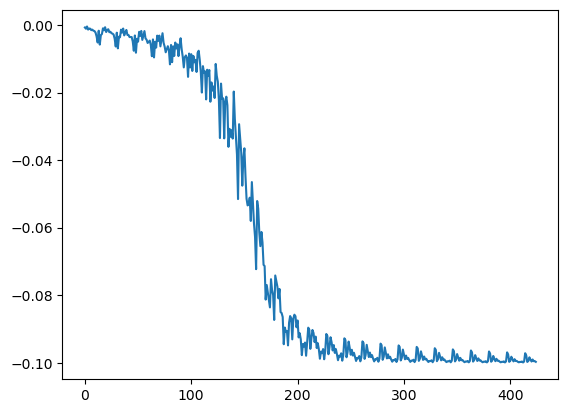

In [99]:
import matplotlib.pyplot as plt
plt.plot(loss_history)